## Predict how much energy will a building consume with Fedot.Industrial

Dataset published on Kaggle, aims to assess the value of energy efficiency improvements. For that purpose, four types of sources are identified: electricity, chilled water, steam and hot
water. The goal is to estimate the **energy consumption in kWh**. Dimensions correspond to the air temperature, dew temperature, wind direction and wind speed. These values were taken hourly during a week, and the output is the meter reading of the four aforementioned sources. In this way, was created four datasets:  **ChilledWaterPredictor**, **ElectricityPredictor**, **HotwaterPredictor**, and **SteamPredictor**.
Link to the dataset - https://www.kaggle.com/code/fatmanuranl/ashrae-energy-prediction2

In [1]:
import pandas as pd
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate

2025-01-28 13:26:50,976 - PyTorch version 2.2.2 available.


The list of basic fedot industrial models for experiment are shown below. We using simple linear machine learning pipelines with 3 different feature generators: Statistical, Reccurence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [2]:
from fedot_ind.core.repository.config_repository import DEFAULT_COMPUTE_CONFIG, DEFAULT_REG_AUTOML_CONFIG, DEFAULT_AUTOML_LEARNING_CONFIG

initial_assumption = {0: ['quantile_extractor', 'treg']}

API_CONFIG = {'industrial_config': {'problem': 'regression'},
              'automl_config': DEFAULT_REG_AUTOML_CONFIG,
              'learning_config': {'learning_strategy': 'from_scratch',
                                  'learning_strategy_params': DEFAULT_AUTOML_LEARNING_CONFIG,
                                  'optimisation_loss': {'quality_loss': 'rmse'}},
              'compute_config': DEFAULT_COMPUTE_CONFIG}
METRIC_NAMES = ('r2', 'rmse', 'mae')
DATASET_NAME = 'ElectricityPredictor'

In [3]:
api_client = ApiTemplate(api_config=API_CONFIG,
                         metric_list=METRIC_NAMES)

Lets check our data.

In [4]:
import numpy as np
from fedot_ind.tools.loader import DataLoader
from fedot_ind.tools.serialisation.path_lib import EXAMPLES_DATA_PATH

train_data, test_data = DataLoader(dataset_name=DATASET_NAME,
                                   folder=EXAMPLES_DATA_PATH).load_data()
features = np.array(train_data[0].tolist()).astype(float)

2025-01-28 13:27:49,237 - Reading data from /Users/lopatenko/Desktop/dev/Fedot.Industrial/examples/data/ElectricityPredictor
2025-01-28 13:27:49,461 - Data read successfully from local folder


In [5]:
features.shape

(567, 4, 168)

Lets visualise our predictors.

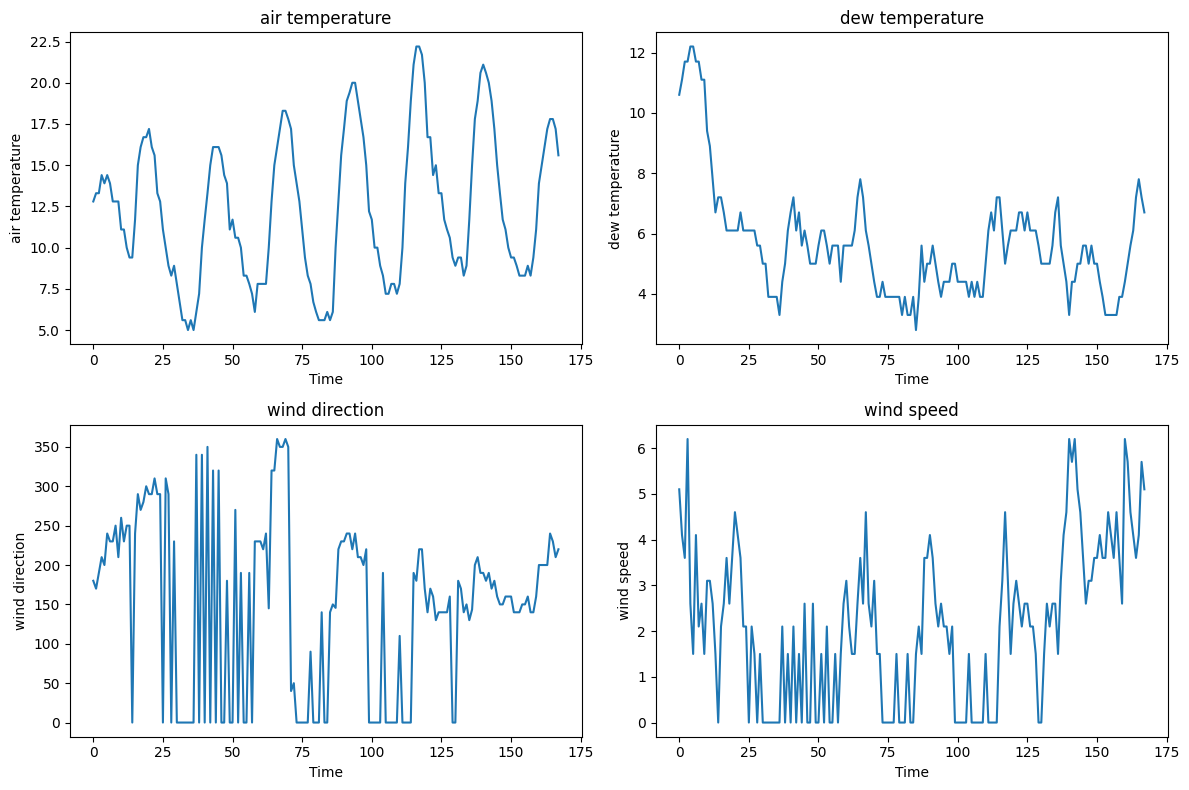

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

feature_names = ['air temperature', 'dew temperature', 'wind direction', 'wind speed']
n_features = len(feature_names)
ncols = 2
nrows = (n_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

for i in range(n_features):
    feature_data = features[1, i, :]
    df = pd.DataFrame(feature_data, columns=[feature_names[i]])
    ax = axes[i]
    df.plot(ax=ax, title=feature_names[i], legend=False)
    ax.set_xlabel('Time')
    ax.set_ylabel(feature_names[i])
plt.tight_layout()
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [8]:
result_dict = api_client.eval(dataset=DATASET_NAME, finetune=True, initial_assumption=initial_assumption)

2024-04-04 15:55:08,487 - Initialising experiment setup
2024-04-04 15:55:08,503 - Initialising Industrial Repository
2024-04-04 15:55:08,632 - Initialising Dask Server
Creating Dask Server
2024-04-04 15:55:09,341 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-04-04 15:55:09,375 - State start
2024-04-04 15:55:10,361 -   Scheduler at: inproc://10.64.4.217/16700/1
2024-04-04 15:55:10,361 -   dashboard at:  http://10.64.4.217:57469/status
2024-04-04 15:55:10,361 - Registering Worker plugin shuffle
2024-04-04 15:55:11,358 -       Start worker at: inproc://10.64.4.217/16700/4
2024-04-04 15:55:11,359 -          Listening to:          inproc10.64.4.217
2024-04-04 15:55:11,359 -           Worker name:                          0
2024-04-04 15:55:11,360 -          dashboard at:          10.64.4.217:57470
2024-04-04 15:55:11,360 - Waiting to connect to: inproc://10.64.4.217/16700/1
2024-04-04 15:55:11,361 - --------

[I 2024-04-04 16:07:41,649] A new study created in memory with name: no-name-680e6081-ecf6-4c24-ba92-32dfad27d4c6


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-04 16:11:33,392] Trial 1 finished with value: 469.3836309717183 and parameters: {'0 || treg | max_features': 0.05775924428054445, '0 || treg | min_samples_split': 20, '0 || treg | min_samples_leaf': 20, '0 || treg | bootstrap': True}. Best is trial 1 with value: 469.3836309717183.
[I 2024-04-04 16:11:33,725] Trial 0 finished with value: 461.5546704823826 and parameters: {'0 || treg | max_features': 0.9172096934223357, '0 || treg | min_samples_split': 6, '0 || treg | min_samples_leaf': 6, '0 || treg | bootstrap': True}. Best is trial 0 with value: 461.5546704823826.
[I 2024-04-04 16:11:34,116] Trial 2 finished with value: 466.0606524541281 and parameters: {'0 || treg | max_features': 0.9000416173564508, '0 || treg | min_samples_split': 17, '0 || treg | min_samples_leaf': 17, '0 || treg | bootstrap': True}. Best is trial 0 with value: 461.5546704823826.
[I 2024-04-04 16:11:34,457] Trial 4 finished with value: 464.40816428292965 and parameters: {'0 || treg | max_features': 0.36

In [9]:
labels = result_dict['labels']
metrics = result_dict['metrics']

In [10]:
metrics

,r2,rmse,mae
0,0.161,470.714,209.547


At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

## AutoML approach

In [ ]:
result_dict_auto = api_client.eval(dataset=DATASET_NAME, finetune=False, initial_assumption=initial_assumption)

In [12]:
auto_labels = result_dict_auto['labels']
auto_metrics = result_dict_auto['metrics']

In [13]:
auto_metrics

,r2,rmse,mae
0,0.087,491.02,212.539


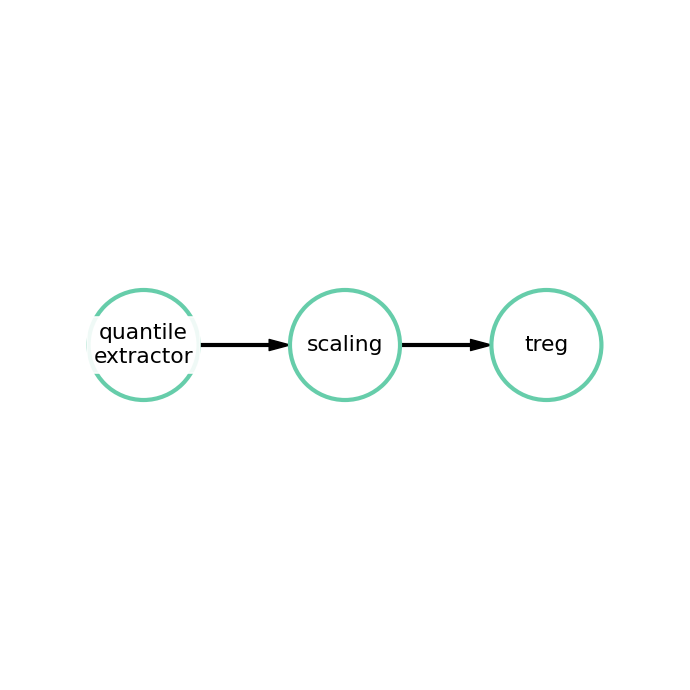

2024-04-04 17:08:10,349 - OperationsAnimatedBar - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-04 17:08:10,450 - MovieWriter ffmpeg unavailable; using Pillow instead.
2024-04-04 17:08:10,451 - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2024-04-04 17:08:15,804 - OperationsAnimatedBar - The animation was saved to "D:\WORK\Repo\Industiral\IndustrialTS\results_of_experiments\history_animated_bars.gif".
2024-04-04 17:08:15,806 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-04 17:08:15,833 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-04 17:08:15,839 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the a

In [14]:
api_client.industrial_class.manager.solver.current_pipeline.show()

# Not implemented yet:

# api_client.industrial_class.plot_operation_distribution(mode='each')
# iapi_client.industrial_class.plot_fitness_by_generation()

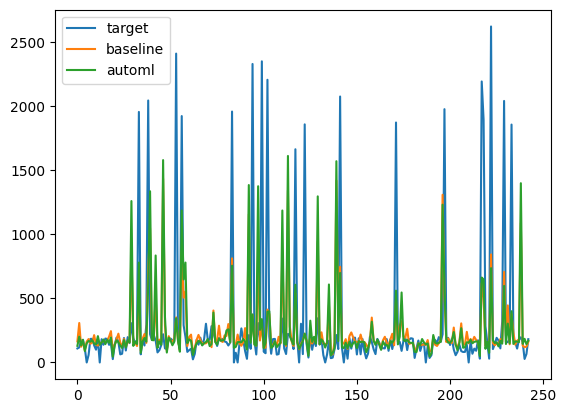

In [15]:
predictions = np.vstack([api_client.test_data[1].flatten(), labels.flatten(), auto_labels.flatten()]).T
all_prediction = pd.DataFrame(predictions,columns=['target', 'baseline', 'automl'])
all_prediction.plot()
plt.show()

## Compare with State of Art (SOTA) models

In [16]:
from fedot_ind.tools.serialisation.path_lib import PROJECT_PATH

df = pd.read_csv(PROJECT_PATH + '/benchmark/ts_regression_sota_results.csv',sep=';')
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)

In [17]:
df['Fedot_Industrial_tuned'] = metrics['rmse'][0]
df['Fedot_Industrial_AutoML'] = auto_metrics['rmse'][0]
df = df.T

In [18]:
df.sort_values('min')['min']

CNN_RMSE                   387.616535
Grid-SVR_RMSE              390.641257
FPCR_RMSE                  399.459870
5NN-DTW_RMSE               407.790548
FPCR-Bs_RMSE               408.199670
5NN-ED_RMSE                424.504623
RandF_RMSE                 456.359415
Fedot_Industrial_tuned     470.714000
FreshPRINCE_RMSE           487.642605
ResNet_RMSE                489.719817
Fedot_Industrial_AutoML    491.020000
RDST_RMSE                  491.072419
ROCKET_RMSE                492.914183
DrCIF_RMSE                 494.923063
FCN_RMSE                   499.100408
SingleInception_RMSE       499.449452
InceptionT_RMSE            506.696071
MultiROCKET_RMSE           506.770267
Ridge_RMSE                 509.119169
TSF_RMSE                   510.156025
RotF_RMSE                  519.799244
XGBoost_RMSE               526.421564
1NN-ED_RMSE                529.096971
1NN-DTW_RMSE               557.562623
RIST_RMSE                  560.257921
Name: min, dtype: float64

In [19]:
df.sort_values('max')['max']

Fedot_Industrial_tuned     470.714000
Fedot_Industrial_AutoML    491.020000
FPCR_RMSE                  522.998212
FPCR-Bs_RMSE               537.381895
5NN-DTW_RMSE               546.981708
Grid-SVR_RMSE              553.666929
CNN_RMSE                   561.795243
5NN-ED_RMSE                562.413046
RDST_RMSE                  575.720140
RandF_RMSE                 589.478468
Ridge_RMSE                 627.513473
ROCKET_RMSE                629.215008
RIST_RMSE                  639.787936
FreshPRINCE_RMSE           640.463800
InceptionT_RMSE            645.057362
DrCIF_RMSE                 646.879703
SingleInception_RMSE       652.585529
ResNet_RMSE                661.954851
TSF_RMSE                   663.258974
MultiROCKET_RMSE           663.968054
RotF_RMSE                  670.442108
FCN_RMSE                   693.068654
XGBoost_RMSE               693.574841
1NN-DTW_RMSE               755.854409
1NN-ED_RMSE                812.146002
Name: max, dtype: float64